In [1]:
from baselines import load_experiments_data, ScipyPeaks, eval_scores
from analysis import moving_avg
from sklearn.preprocessing import MinMaxScaler
import json
import matplotlib.pyplot as plt

## Preparations
only need to run this code once to create ```baseline_vis_data.json```

In [ ]:
# 1st and 3rd matches are train set, 2nd match is test set
matches = load_experiments_data("nalcs_*g[13]", load_random=None, random_state=None, data_path="./data")

In [ ]:
hl_msg_data = dict()
for name, data in matches.items():
    hl_msg_data[name] = dict()
    hl_msg_data[name]["msg_dens"] = MinMaxScaler().fit_transform(moving_avg(data["chat_message_density"], N=1500).reshape(-1, 1)).ravel().tolist()
    hl_msg_data[name]["highlights"] = data["highlights"].tolist()

In [26]:
with open("data/baseline_vis_data.json", "w") as out_file:
    json.dump(hl_msg_data, out_file)

In [21]:
md, hl = hl_msg_data[list(hl_msg_data.keys())[0]]["msg_dens"], hl_msg_data[list(hl_msg_data.keys())[0]]["highlights"]

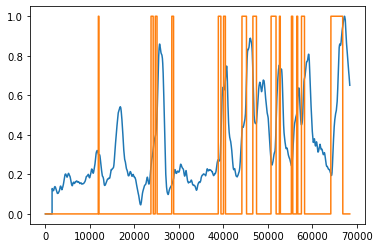

In [24]:
plt.plot(list(range(len(md))), md)
plt.plot(list(range(len(hl))), hl)
plt.show()

## Interactive Visualisation

callbacks for dynamically changing visualizations: https://dash.plotly.com/basic-callbacks

plotly/dash in jupyter: https://medium.com/plotly/introducing-jupyterdash-811f1f57c02e

baseline based on: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks

In [2]:
with open("data/baseline_vis_data.json", "r") as in_file:
    hl_msg_data = json.load(in_file)
matches = list(sorted(hl_msg_data.keys()))

In [13]:
import plotly.express as px
import dash
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

# Build App
app = JupyterDash(__name__)
# Create server variable with Flask server object for use with gunicorn
server = app.server

app.layout = html.Div([
    html.H1("SciPy Find Peaks Parameters on highlight data"),
    # graph component
    dcc.Graph(id='graph'),
    html.Label([
        "match 1: the name of the match for which data should be displayed",
        dcc.Dropdown(
            id='match1-dropdown', clearable=False,
            value=matches[0], options=[
                {'label': m, 'value': m}
                for m in matches
            ])
    ]),
    # match selector
    html.Label([
        "scale: use every scale-th data point",
        dcc.Slider(1,100,1,
            value=10,
            marks=None,
            id="scale-slider",
            tooltip={"placement": "bottom", "always_visible": True}
        )
    ]),
    # parameter selectors
    html.Label([
        "shift: shift by shift*width",
        dcc.Slider(-1,1,0.1,
            value=0,
            marks=None,
            id="shift-slider",
            tooltip={"placement": "bottom", "always_visible": True}
        )
    ]),
    html.Label([
        "width-scale: width = width-scale*width of recognized peak",
        dcc.Slider(0,2,0.01,
            value=1,
            marks=None,
            id="width-scale-slider",
            tooltip={"placement": "bottom", "always_visible": True}
        )
    ]),
    html.Label([
        "min-max-width: minimum/maximum width for recognizing the peak",
        dcc.RangeSlider(0,10000,50,
            value=[50, 500],
            marks=None,
            id="width-slider",
            tooltip={"placement": "bottom", "always_visible": True}
        )
    ]),
    html.Label([
        "prominence: The prominence of a peak measures how much a peak stands out from the surrounding baseline of the signal and is defined as the vertical distance between the peak and its lowest contour line.",
        dcc.Slider(0,1,0.01,
            value=0.14,
            marks=None,
            id="prominence-slider",
            tooltip={"placement": "bottom", "always_visible": True}
        )
    ]),
    html.Label([
        "rel-height: Chooses the relative height at which the peak width is measured as a percentage of its prominence.",
        dcc.Slider(0,1,0.01,
            value=0.6,
            marks=None,
            id="rel-height-slider",
            tooltip={"placement": "bottom", "always_visible": True}
        )
    ]),
    # output evaluation metrics
    html.Div([
        "Evaluate current configuration on training set (may take a while for low 'scale' values)",
        html.Div(id="results"),
        html.Button('Calculate', id='submit-calc', n_clicks=0),
        dcc.RadioItems(['use button', 'keep updated'], 'use button', id="keep-updated")
    ])
])

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    Output('results', 'children'),
    [Input("match1-dropdown", "value"),
    Input("scale-slider", "value"),
    Input("shift-slider", "value"),
    Input("width-slider", "value"),
    Input("width-scale-slider", "value"),
    Input("rel-height-slider", "value"),
    Input("prominence-slider", "value"),
    Input("submit-calc", "n_clicks"),
    Input("keep-updated", "value"),
    ]
)
def update_figure(match1, scale, shift, width, width_scale, rel_height, prominence, submit_calc, keep_updated):
    # check which component triggered the update
    ctx = dash.callback_context

    if not ctx.triggered:
        button_id = 'No clicks yet'
    else:
        button_id = ctx.triggered[0]['prop_id'].split('.')[0]
    
    ssp_params = {
        "shift": shift,
        "width_scale": width_scale,
        "scipy_params":{
            "width": width,
            "rel_height": rel_height,
            "prominence": prominence
        }
    }
    
    cur_params = ssp_params
    
    x = list(range(len(hl_msg_data[match1]["msg_dens"][::scale])))
    msg_dens = hl_msg_data[match1]["msg_dens"][::scale]
    spp = ScipyPeaks(**ssp_params).predict(msg_dens)
        
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=hl_msg_data[match1]["highlights"][::scale],
                        mode='lines',
                        name='highlights'))
    fig.add_trace(go.Scatter(x=x, y=msg_dens,
                        mode='lines',
                        name='message_density'))
    fig.add_trace(go.Scatter(x=x, y=spp,
                        mode='lines',
                        name='ScipyPeaks'))
    
    evaluation = {"precision": [0,0],
            "recall": [0,0],
            "f-score": [0,0],
            "accuracy": 0
            }
        
    # calculate evaluation if button is clicked
    if button_id == "submit-calc" or keep_updated == "keep updated":
        total_msg_dens = list()
        total_hl_data = list()

        for n, dat in hl_msg_data.items():
            total_msg_dens.extend(dat["msg_dens"][::scale])
            total_hl_data.extend(dat["highlights"][::scale])
            
        pred = ScipyPeaks(**cur_params).predict(total_msg_dens)
        evaluation = eval_scores(total_hl_data, pred)
        
    print(evaluation["precision"])
    eval_result = html.Table([
                    html.Tr([html.Th('Precision'),
                             html.Th('Recall'),
                             html.Th('F-score'),
                             html.Th('Accuracy')]),
                    html.Tr([html.Td("{:.5f}".format(evaluation["precision"])),
                             html.Td("{:.5f}".format(evaluation["recall"])),
                             html.Td("{:.5f}".format(evaluation["f-score"])),
                             html.Td("{:.5f}".format(evaluation["accuracy"]))])
    ])
    
    return fig, eval_result


In [14]:
# Run app and display result inline in the notebook
app.run_server(mode='jupyterlab')

[0, 0]


In [10]:
# Run app and display result inline in the notebook
app.run_server(mode='inline')